<img src="kbo_2102hz84_and_kbo_2102he85.jpg">
New Horizon picture of two TNOs (Credits: NASA)

## Centaurs and Trans-Neptunian Objects (TNOs): a single family of objects?
#### AstroAnalytics: Data science in the astrophysical and planetary science

_version 1.0 (12/2/2018)_

_version 1.1 (19/3/2018): failed attempt to classify TNOs versus Centaurs with their colors_

_version 1.2 (13/6/2018): add tpot classification genetic optimization method_

_version 2.0 (29/5/2024): Python 3.9_

Wing-Fai Thi

If you are bored of tutorials using the default datasets like the Iris or the Titanic to learn Data Science, here I show how to use Data Science techniques to analyse astrophysical or planetary science data. The tutorials are based on actual analyses published in scientifics journals and the datasets are available online or can be copied from the articles. Other tutorials are more classic in the sense that no astrophysical data will be used.


### Scientific background

#### Centaurs

Centaurs are small solar system bodies (minor planets) with a semi-major axis between those of the outer planets (Uranus, Neptune). The centaurs lie generally inwards of the Kuiper belt and outside the Jupiter trojans. They have unstable orbits because they cross or have crossed the orbits of one or more of the giant planets; almost all their orbits have dynamic lifetimes of only a few million years. Centaurs typically behave with characteristics of both asteroids and comets. 

The colours of centaurs are very diverse, which challenges any simple model of surface composition. In the diagram, the colour indices are measures of apparent magnitude of an object through blue (B), visible (V) (i.e. green-yellow) and red (R) filters. The diagram illustrates these differences (in exaggerated colours) for all centaurs with known colour indices. For reference, two moons: Triton and Phoebe, and planet Mars are plotted (yellow labels, size not to scale).

<img src="TheKuiperBelt_Albedo_and_Color.svg.png" />
Credits Wikipedia

Centaurs appear to be grouped into two classes:

- very red – for example 5145 Pholus
- blue (or blue-grey, according to some authors) – for example 2060 Chiron

There are numerous theories to explain this colour difference, but they can be divided broadly into two categories:
- the colour difference results from a difference in the origin and/or composition of the centaur (see origin below)
- the colour difference reflects a different level of space-weathering from radiation and/or cometary activity.


### How to overcome the observation overkill? How to make sense of large datasets?
- Cluster analysis uses the data themselves creates groupings of beings or objects.
- PCA identifies a few components that you can assemble from a large set of measured variables.
- PCA and cluster analysis complement each other and actually nurture each other.
- Both are called unsupervised machine learning methods.

### The data are taken from:
- Barucci et al. 2001 A&A 371, 1150
- DeMeo et al. 2009 A&A 493, 283
- a subset of the data from https://sbn.psi.edu/pds/asteroid

### Interesting websites
[JPL](https://ssd.jpl.nasa.gov/sbdb.cgi?sstr=120132)
[IAU Minor planet center](https://minorplanetcenter.net/iau/lists/Centaurs.html)

### References:
- Razali et al. (2001) Journal of Modelling and Analytics 2,21. Power comparisons of Shapiro-Wilk, Kolmogorov-Smirnov, Lillefors and Anderson-Darling tests. The authors claim that test with the best power for agiven significance in deacring order are:
    - Shapiro-Wilk
    - Anderson-Darling
    - Kolmogorov-Smirnov
    - Lillefors
- Pexinho et al. atro-oh 1206.3153

### Aim of the notebook:
- We will analyse the PCA by clustering of the colors of a sample of Centaurs and TNOs.
- We will confirm the two grouping by color.
- There is no difference between Centaurs and TNOs in the colors.
- Generate a mock TNO/Centaur sample using Principle Component Analysis
- We will explore also the Factor Analysis and Nonnegative Factorization methods

In [1]:
print(__doc__)
import numpy as np
import pandas as pd
# PCA and Factor Analysis
from sklearn.decomposition import PCA,FactorAnalysis
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from sklearn.preprocessing import StandardScaler
# K-mean algorithm
from sklearn.cluster import KMeans
# Local Outlier Factor
from sklearn.neighbors import LocalOutlierFactor
from sklearn.covariance import EllipticEnvelope
from scipy.stats import rv_discrete
from scipy.stats import spearmanr,ks_2samp, chi2_contingency, anderson
from scipy.stats import probplot
np.random.seed(42)
%matplotlib inline
np.__version__

Automatically created module for IPython interactive environment


'1.26.4'

In [2]:
# Read the data
df=pd.read_csv('aa2001B_data.csv', header=0)
# List the objects
df = df.drop([0]) # drop the Sun
df[['Objects','Type','B-V','V-R','V-I','V-J']].head()

,Objects,Type,B-V,V-R,V-I,V-J
1,1993 SC,TNO,1.04,0.65,1.39,2.27
2,1994 TB,TNO,1.03,0.76,1.41,2.54
3,1995 QY9,TNO,0.71,0.47,0.87,2.01
4,1996 TL66,TNO,0.69,0.31,0.71,1.26
5,1996 TO66,TNO,0.67,0.37,0.76,0.86


In [3]:
# Select the columns to be used in the analysis
df_data = df[['B-V', 'V-R', 'V-I', 'V-J', 'Class']]

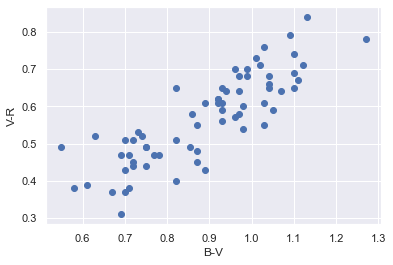

In [4]:
plt.scatter(df_data['B-V'],df_data['V-R'])
plt.xlabel('B-V')
plt.ylabel('V-R')
plt.show()

Two groups stand clear in the (V-R) versus (B-V) diagram for all the objects. We can check whether groups can be seen for other color combinations.

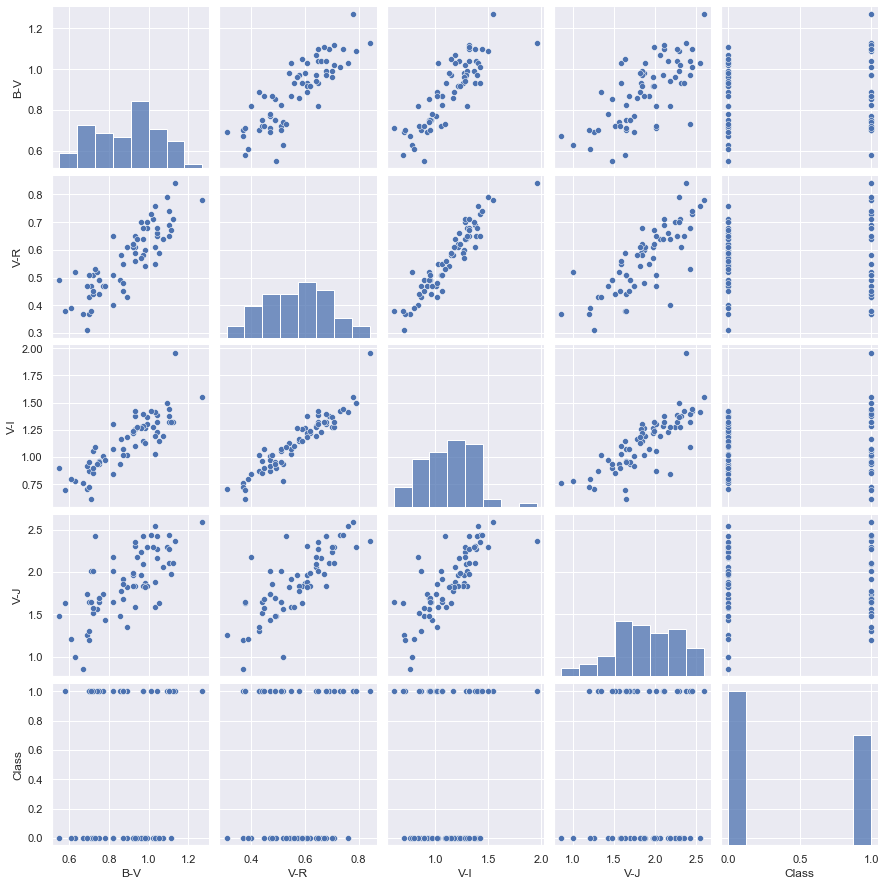

In [5]:
# Basic correlogram using seaborn
sns.pairplot(df_data)
plt.show()

The outlier points correspond to the Sun. We make probability plots. The normal probability plot (Chambers et al. 1983) is a graphical technique for assessing whether or not a data set is approximately normally distributed. The normal probability plots are particularly useful for small sample size.

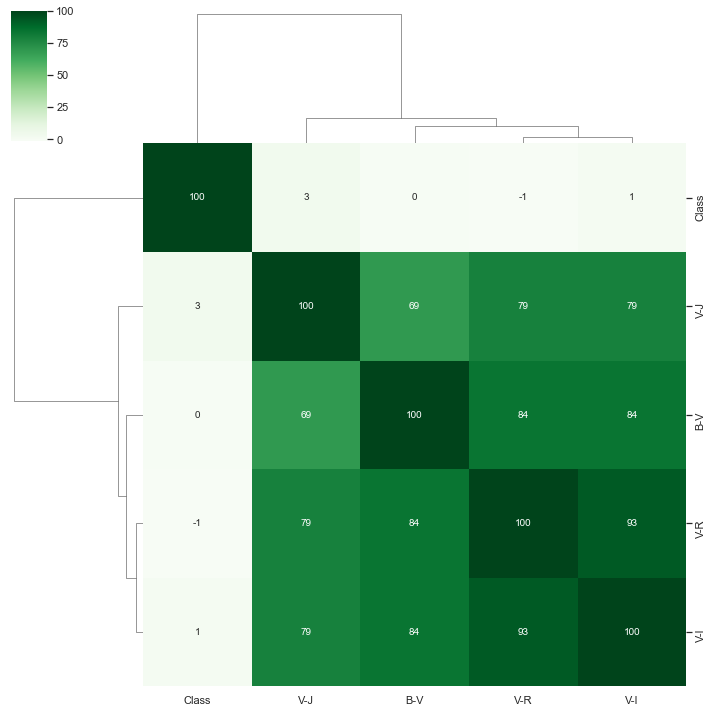

In [6]:
corr = df_data.corr().mul(100).astype(int)
sns.clustermap(data=corr, annot=True, fmt='d', cmap='Greens')
plt.show()

In [7]:
from matplotlib.collections import EllipseCollection

def plot_corr_ellipses(data, ax=None, **kwargs):

    M = np.array(data)
    if not M.ndim == 2:
        raise ValueError('data must be a 2D array')
    if ax is None:
        fig, ax = plt.subplots(1, 1, subplot_kw={'aspect':'equal'})
        ax.set_xlim(-0.5, M.shape[1] - 0.5)
        ax.set_ylim(-0.5, M.shape[0] - 0.5)

    # xy locations of each ellipse center
    xy = np.indices(M.shape)[::-1].reshape(2, -1).T

    # set the relative sizes of the major/minor axes according to the strength of
    # the positive/negative correlation
    w = np.ones_like(M).ravel()
    h = 1 - np.abs(M).ravel()
    a = 45 * np.sign(M).ravel()

    ec = EllipseCollection(widths=w, heights=h, angles=a, units='x', offsets=xy,
                           transOffset=ax.transData, array=M.ravel(), **kwargs)
    ax.add_collection(ec)

    # if data is a DataFrame, use the row/column names as tick labels
    if isinstance(data, pd.DataFrame):
        ax.set_xticks(np.arange(M.shape[1]))
        ax.set_xticklabels(data.columns, rotation=90)
        ax.set_yticks(np.arange(M.shape[0]))
        ax.set_yticklabels(data.index)

    return ec

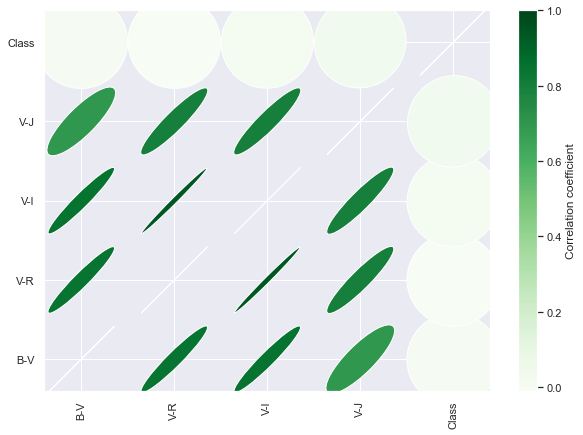

In [8]:
fig, ax = plt.subplots(1, 1,figsize=(10, 7))
m = plot_corr_ellipses(df_data.corr(), ax=ax, cmap='Greens')
cb = fig.colorbar(m)
cb.set_label('Correlation coefficient')
ax.margins(0.1)

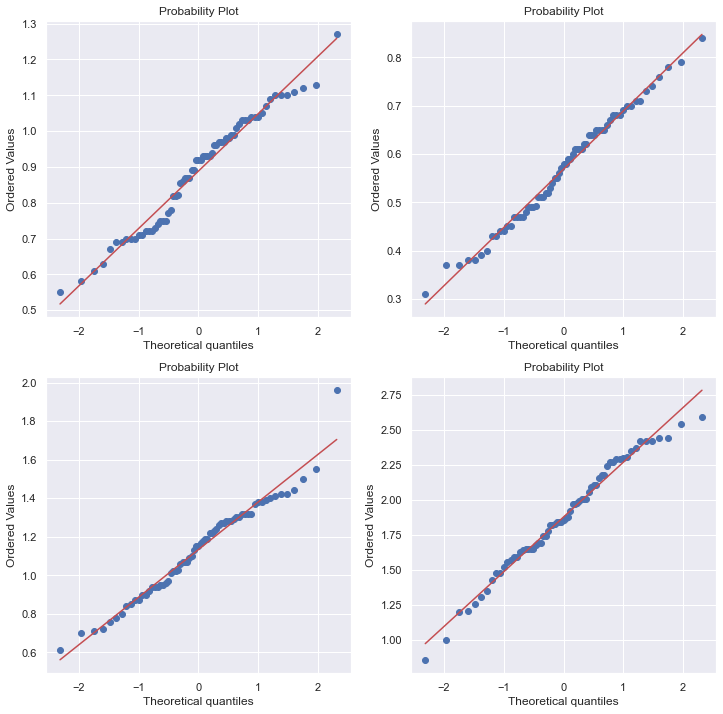

In [9]:
ax1 = plt.subplots(figsize=(12, 12))
ax1 = plt.subplot(221)
p1=probplot(df['B-V'], plot=plt)
ax2 = plt.subplot(222)
p2=probplot(df['V-R'], plot=plt)
ax3 = plt.subplot(223)
p3=probplot(df['V-I'],plot=plt)
ax4 = plt.subplot(224) 
p4=probplot(df['V-J'], plot=plt)

The Quantile-quantale plot (Q-Q) plot is a graphical technique for determing if two data sets come from populations with a common distribution. A Q-Q plot is a plot of the quantiles of the first data set against the quantils of the second data set.
Here significant departure from a normal distribution is seen in all the colors.

Despite the small sample size, the probability plots show that the colors are not normally-distributed. The choice of the bins can affect our interpretation of the underlaying distribution. We can further use 1D Kernel Density Estimation to confirm the results.

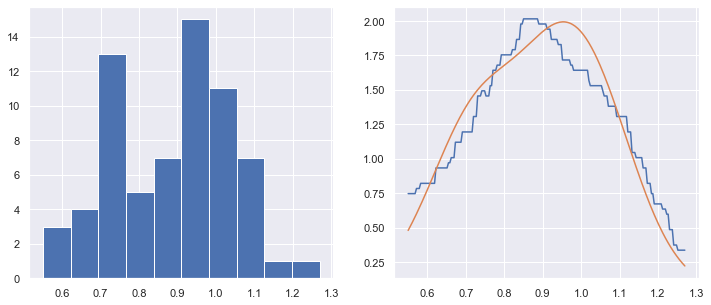

In [10]:
from sklearn.neighbors import KernelDensity
# tophat KDE
X1 = np.array(df['B-V'])
X1 = X1.reshape(X1.size,1)
npoints = 200
Xkde=np.linspace(df['B-V'].min(),df['B-V'].max(),npoints).reshape(npoints, 1)
kde_tophat = KernelDensity(kernel='tophat',bandwidth=0.2).fit(X1)
log_dens_tophat = kde_tophat.score_samples(Xkde)
kde_gaussian = KernelDensity(kernel='gaussian',bandwidth=0.1).fit(X1)
log_dens_gaussian = kde_gaussian.score_samples(Xkde)

plt.subplots(figsize=(12, 5))
plt.subplot(121)
plt.hist(X1, bins=10)
plt.subplot(122)
plt.plot(Xkde[:, 0], np.exp(log_dens_tophat))
plt.plot(Xkde[:, 0], np.exp(log_dens_gaussian))
plt.show()

We can use a cluster analysis tool to separate the two groups in the (V-R) versus (B-V) diagram. The different colors are correlated variables because they carry basically the same information. The data are well-separate enough for the k-means algorithm to perform well (it tends to find blobs).

Cluster centers:


,B-V,V-R
0,0.999237,0.652105
1,0.732000,0.452214


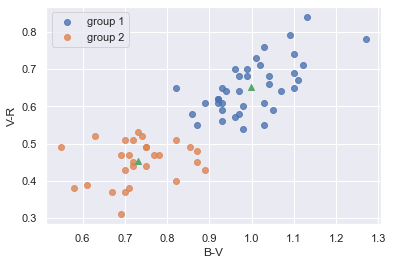

In [11]:
selected_colors = ['B-V', 'V-R']
df_color = df_data[selected_colors]
X_color = np.array(df_color)
X = X_color[1:X_color.shape[0], :]
k_means = KMeans(n_clusters=2, random_state=19080)
k_means.fit(X)
dfk=pd.DataFrame(k_means.cluster_centers_,columns=selected_colors)

klabels = k_means.labels_
plt.scatter(X[klabels == 0,0], X[klabels == 0,1], alpha=0.8, label='group 1')
plt.scatter(X[klabels == 1,0], X[klabels == 1,1], alpha=0.8, label='group 2')
plt.scatter(k_means.cluster_centers_[:, 0], k_means.cluster_centers_[:, 1], marker="^")
plt.xlabel('B-V')
plt.ylabel('V-R')
plt.legend(frameon=True) 
print("Cluster centers:")
dfk

The groupings are found by the k-means method. The group centers are indicatd by the red triangles. The point on the extreme right at B-V = 1.27 is Centaur 5145 Pholus.

Now we go further in the analysis to include all the colors. After scaling the data, we will perform a PCA using the scikit-learn module PCA.

In [12]:
# In sklearn PCA does not feature scale the data beforehand.
# PCA with 4 components
df_data_noClass = df[['B-V', 'V-R', 'V-I', 'V-J']]
X = np.array(df_data_noClass)
scaler = StandardScaler().fit(X)
X = scaler.transform(X)
pca = PCA(n_components=4,svd_solver ='full')
pca_model = pca.fit(X)
# transform a numpy array into a pandas' dataframe
pca_components=pd.DataFrame(np.vstack((np.transpose(pca.components_), pca.explained_variance_ratio_ * 100.)))
colors = pd.DataFrame(['B-V','V-R','V-I','V-J','% explained'])
df_pca = pd.concat([colors,pca_components],axis='columns')
df_pca.columns=['Color','PCA 1', 'PCA 2', 'PCA 3', 'PCA 4']
print("Total variance explained",pca.explained_variance_ratio_.sum() * 100.)
df_pca

Total variance explained 99.99999999999999


,Color,PCA 1,PCA 2,PCA 3,PCA 4
0,B-V,0.489064,-0.562768,0.666194,-0.017162
1,V-R,0.517653,-0.103442,-0.485356,-0.696968
2,V-I,0.518469,-0.108059,-0.453432,0.716877
3,V-J,0.473330,0.812967,0.339139,-0.005276
4,% explained,86.631607,7.743130,4.115266,1.509997


The factor loadings differ from the publihed values in Barucci et al. due to our larger dataset. All the colors contribute to the first component, consistent with the knowledge that all the colors carry similar information. The second component on the other hand reflects mostly the V-J color.

PCA does depend on the dataset. Here we performed PCA on a much larger number of objects than in Barucci et al. One can recover the PCA results in Barucci et al. if only the first 22 TNOs/Centaurs are used for the analysis.

In [13]:
# Compute the eigenvalues
n_samples = X.shape[0]
X1 = np.copy(X)
X1 -= np.mean(X1, axis=0) #center the data and compute the sample covariance matrix.
# two ways to compute the covariance matrix
cov_matrix = np.dot(X1.T, X1) / n_samples
#cov_matrix = np.cov(X.T)
print('Covariance matrix \n%s' %cov_matrix)
print("Eigenvalues")
for eigenvector in pca.components_:
    print(np.dot(eigenvector.T, np.dot(cov_matrix, eigenvector)))


Covariance matrix 
[[1.         0.8428121  0.84703547 0.69766291]
 [0.8428121  1.         0.93954321 0.7961425 ]
 [0.84703547 0.93954321 1.         0.79765047]
 [0.69766291 0.7961425  0.79765047 1.        ]]
Eigenvalues
3.4652642618477834
0.30972521363520344
0.16461062939947407
0.0603998951175377


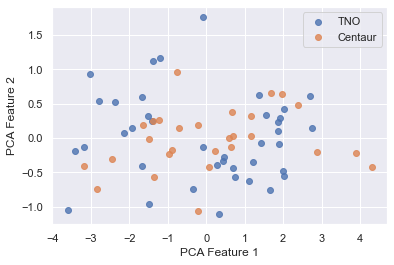

In [14]:
wTNO = np.array(np.where(df_data['Class']==0)) - 1
wCentaur = np.array(np.where(df_data['Class']==1)) - 1
wTNO = wTNO.reshape(wTNO.size)
wCentaur = wCentaur.reshape(wCentaur.size)
Xpca = pca.transform(X)

def plot_Data(X,Y,lab,leg1,leg2):
    plt.scatter(X[:, 0], X[:, 1], alpha=0.8, label=leg1)
    plt.scatter(Y[:, 0], Y[:, 1], alpha=0.8, label=leg2)
    plt.legend(frameon=True)    
    plt.xlabel(lab+' Feature 1')
    plt.ylabel(lab+' Feature 2')
    plt.show()
    
plot_Data(Xpca[wTNO,:],Xpca[wCentaur,:],'PCA','TNO','Centaur')

The 2 principal components account for close to 95% of the variance. The histogram for the 2 PCA features.

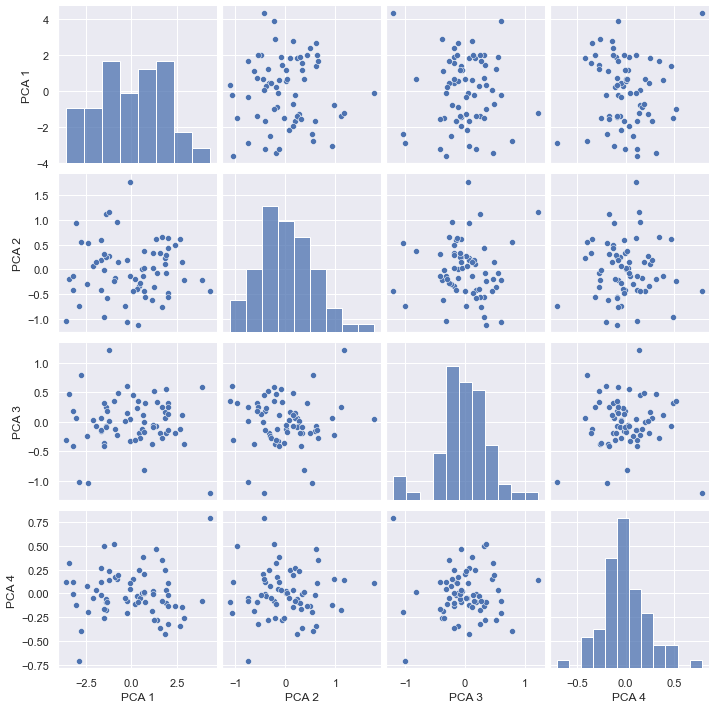

In [15]:
df_Xpca = pd.DataFrame(Xpca)
df_Xpca.columns = ['PCA 1', 'PCA 2', 'PCA 3', 'PCA 4']
sns.pairplot(df_Xpca)
plt.show()

The PCA components are uncorrelated as expected. The distribution of the PCA 2 components show an extreme value.

In [16]:
# outlier: strong PCA 2
woutlier = np.where(Xpca[:,1] > 1.5)
df_Xpca.iloc[woutlier[0],:]

,PCA 1,PCA 2,PCA 3,PCA 4
61,-0.083069,1.766552,0.050261,0.111255


In [17]:
df.iloc[woutlier[0],:]

,Objects,Type,B-V,err(B-V),V-R,err(V-R),V-I,err(V-I),V-J,err(V-J),Class,Ref
62,2000 OK67,TNO,0.73,0.11,0.53,0.07,1.09,0.1,2.42,0.08,0,Nasa


Component 2 is a combination a positive loading from V-J and a negative loading from B-V. PCA may indicate that the color difference between V-J and B-V for this object is unsual.

#### Factor Analysis

We will now use an other method called Factor Analysis (FA). Factor Analysis is a generalization of PCs in which, rather than seeking a full-rank linear transformation with second-moment properties, one allows non-full-rank linear transformations.

FA is used to describe the covariance relationships among many variables in terms of a few underlying, but unobservable (latent in the statistical vocabulary), random quantitie called factors.  Factor analysis can be used in situations where the variables can be grouped according to correlations so that all variables within a particular group are highly correlated among themselves but have relatively small correlation with variables in a different group. Here for example, the colors are correlated with each other.

Thus each group of variables represents a single underlying factor (that we can called index, like temperature index, mass index, ...). Factor analysis can be considered as an extension of PCA.


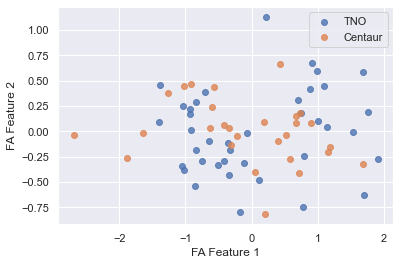

Factor loadings


,Color,Factor 1,Factor 2
0,B-V,0.137568,0.021032
1,V-R,0.113826,-0.000899
2,V-I,0.236469,0.000280
3,V-J,0.314553,-0.059868


In [18]:
fa= FactorAnalysis(n_components=2, max_iter=50,copy=True,svd_method='lapack')
X = np.array(df_data_noClass)
fa.fit(X)
Xfa = fa.transform(X)
plot_Data(Xfa[wTNO, :],Xfa[wCentaur, :], 'FA', 'TNO', 'Centaur')
colors_fa=pd.DataFrame(['B-V', 'V-R', 'V-I', 'V-J'])
# the FA components are rotated by 180 degrees
df_fa = pd.DataFrame(-np.transpose(fa.components_))
df_fa = pd.concat([colors_fa,df_fa], axis='columns')
df_fa.columns=['Color','Factor 1','Factor 2']
print("Factor loadings")
df_fa

FA Feature 1 shows clearly a separation in two groups. Both groups contain Centaurs and TNOs. We can use the k-means algorithm to perform a cluster analsysis and find these two groups. 
The k-means method is a trial-and-error method
The k-means approach to cluster analysis forms, and repeatedly re-forms, groups until the distances between objects with clusters are minimized. At the same the distances between clusters are maximized.
The drawbacks is the number of clusters k is set a priori by the user. Sometime an expert will be able to determine the number of clusters required.

In [19]:
k_means = KMeans(n_clusters=2, random_state=19080)
k_means.fit(Xfa)
print("Cluster centers:")
dfk=pd.DataFrame(k_means.cluster_centers_, columns=['Factor 1', 'Factor 2'])
dfk

Cluster centers:


,Factor 1,Factor 2
0,-0.754172,-0.046392
1,0.930145,0.057217


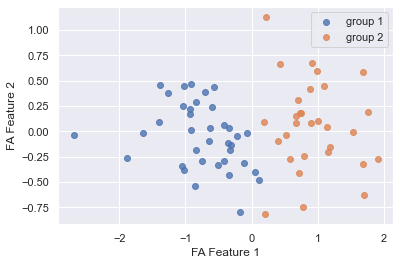

In [20]:
klabels = k_means.labels_
plot_Data(Xfa[klabels == 0, :], Xfa[klabels==1, :],'FA', 'group 1', 'group 2')

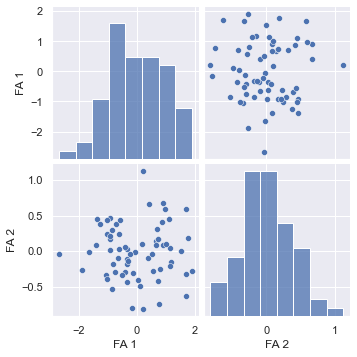

In [21]:
df_Xfa=pd.DataFrame(Xfa)
df_Xfa.columns=['FA 1', 'FA 2']
sns.pairplot(df_Xfa)
plt.show()

In [22]:
def plot_outliers(title):
    plt.title(title)
    plt.contourf(xx, yy, ZZ, cmap=plt.cm.Blues_r)
    a = plt.scatter(Xfa[:, 0], Xfa[:, 1], c='white',
                edgecolor='k', s=20)
    b = plt.scatter(Xfa[woutliers, 0], Xfa[woutliers, 1], c='red',
                edgecolor='k', s=20)
    plt.axis('tight')
    plt.xlim((-4, 4))
    plt.ylim((-2, 2))
    plt.legend([a, b],
           ["normal observations",
            "potential abnormal observations"],
           loc="upper left")
    plt.xlabel('FA 1')
    plt.ylabel('FA 2')
    plt.show()

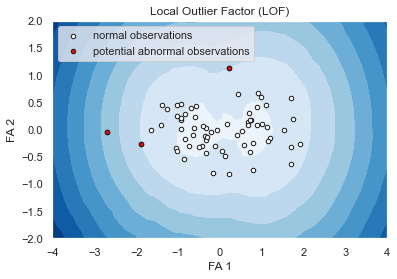

In [23]:
# fit the model
clf = LocalOutlierFactor(n_neighbors=20, novelty=False)
y_pred = clf.fit_predict(Xfa)
woutliers = np.where(y_pred == -1)
wok = np.where(y_pred == 1)

# plot the level sets of the decision function
clf = LocalOutlierFactor(n_neighbors=20, novelty=True)
clf.fit(Xfa)
xx, yy = np.meshgrid(np.linspace(-4, 4, 50), np.linspace(-2, 2, 50))
ZZ = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
ZZ = ZZ.reshape(xx.shape)
plot_outliers("Local Outlier Factor (LOF)")

There are potentially two strong outliers.

0.8955223880597015


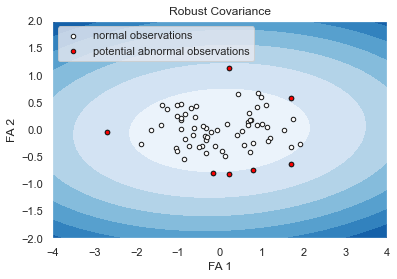

In [24]:
#help("sklearn.covariance.EllipticEnvelope")
outliers_fraction = 0.1
clf = EllipticEnvelope(contamination=outliers_fraction)
y_pred = clf.fit_predict(Xfa)
woutliers = np.where(y_pred == -1)
wok = np.where(y_pred == 1)
print(np.array(wok).size / Xfa.shape[0])
xx, yy = np.meshgrid(np.linspace(-4, 4, 50), np.linspace(-2, 2, 50))
ZZ = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
ZZ = ZZ.reshape(xx.shape)
plot_outliers("Robust Covariance")

In [25]:
wout = np.array(woutliers)
wout = wout.reshape(wout.size)
df_out = pd.concat((df.iloc[wout,0:2],df_Xfa.iloc[wout,:]),axis=1)
df_out

,Objects,Type,FA 1,FA 2
5,1996 TO66,TNO,NaN,NaN
22,1998 SG35,Centaur,NaN,NaN
31,1996 TL66,Centaur,NaN,NaN
35,2001 KX76 Ixion,TNO,NaN,NaN
41,2001 UR163,Centaur,NaN,NaN
61,2003 FY128,TNO,0.213417,1.129090
62,2000 OK67,TNO,NaN,NaN
4,NaN,NaN,1.702719,-0.629326
21,NaN,NaN,0.784326,-0.744003
30,NaN,NaN,1.688500,0.588536


The last two objects are well away from the group center.

In [26]:
# 2 extreme outliers
woutlier = np.where(Xfa[:,1] > 1.0) # select the outlier point in FA 2
df_Xfa.iloc[woutlier[0],:]

,FA 1,FA 2
61,0.213417,1.12909


In [27]:
df.iloc[woutlier[0],:]

,Objects,Type,B-V,err(B-V),V-R,err(V-R),V-I,err(V-I),V-J,err(V-J),Class,Ref
62,2000 OK67,TNO,0.73,0.11,0.53,0.07,1.09,0.1,2.42,0.08,0,Nasa


In [28]:
woutlier = np.where(Xfa[:,0] < -2.0) # select the outlier point in FA 2
df_Xfa.iloc[woutlier[0],:]

,FA 1,FA 2
40,-2.687111,-0.038713


In [29]:
df.iloc[woutlier[0],:]

,Objects,Type,B-V,err(B-V),V-R,err(V-R),V-I,err(V-I),V-J,err(V-J),Class,Ref
41,2001 UR163,Centaur,1.13,0.05,0.84,0.03,1.96,0.07,2.37,0.06,1,Nasa


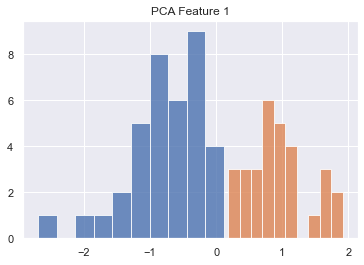

In [30]:
plt.hist(Xfa[klabels == 0,0],alpha=0.8)
plt.hist(Xfa[klabels == 1,0],alpha=0.8)
plt.title('PCA Feature 1')
plt.show()

The analysis has been performed with all the data at hand. Compared to the original analysis, it shows changes in the PCA.

Conclusions:
- PCA depends on the dataset at hand.
- Both outliers stress the use of PCA to find outliers
- One should further check the actual measurements to ensure that these outliers are not caused by typos or artifacts.
- However the conclusions of the Barucci et al. paper holds with the large dataset so far.

Future work:
- generate random TNOs/Centaurs based on the color distribution and build a mock-up sample
- perform the PCA/FA and check for outliers

In [31]:
# pgmpy, PaCAL copulalib
nbins = 10
npoints = 10
bw = 0.3
nrandom = df.shape[0]*10
ind = np.arange(0,npoints,1)
Xrpca= np.empty((nrandom,4))
df_Xpca2 = df_Xpca.copy()    # create a copy of the data frame
#df_Xpca2.drop(df_Xpca2.index[61],inplace=True) # drop the outlier

Because the PCA components are less correlated for non-normal distrbutions and uncorrelated for normal distributions one can draw random samples using only the marginal PCA component distribution and perform an inverse PCA tranform to obtain the original feature distributions.

In [ ]:
pca_dist=[df_Xpca2['PCA 1'], df_Xpca2['PCA 2'], df_Xpca2['PCA 3'], df_Xpca2['PCA 4']]
for i, dist in enumerate(pca_dist):
    # here we can either use the histogram or perform a Kernel density fit
    # to the data
    data = np.array(dist)
    data = data.reshape(data.size,1)
    x = np.linspace(dist.min(),dist.max(),npoints).reshape(npoints,1)
    kde_tophat = KernelDensity(kernel = 'gaussian',bandwidth=bw).fit(data)
    px = (10**kde_tophat.score_samples(x))
    x = x.reshape(npoints)
    #px, x= np.histogram(dist,nbins,density=True) # directly observed data
    px = px/px.sum()
    idx = rv_discrete(values=(ind,px)).rvs(size=nrandom) 
    dx  = x[1]-x[0]
    xval = x[0:npoints]
    Xrpca[:, i] = xval[idx]+np.random.random(nrandom) * dx

df_Xrpca=pd.DataFrame(Xrpca)
df_Xrpca.columns=['PCA 1', 'PCA 2', 'PCA 3', 'PCA 4']
sns.pairplot(df_Xrpca)
plt.show()

In [ ]:
plt.subplots(figsize=(12, 5))
plt.subplot(121)
plt.scatter(Xrpca[:, 0], Xrpca[:, 1], alpha=1.0, label='Mock', marker='o')
plt.scatter(Xpca[:, 0],Xpca[:, 1], alpha=1.0, label='Real')
plt.xlabel('PCA Feature 1')
plt.ylabel('PCA Feature 2')
plt.legend()
plt.subplot(122)
plt.scatter(Xrpca[:, 2], Xrpca[:, 3], alpha=1.0, label='Mock', marker='o')
plt.scatter(Xpca[:, 2],Xpca[:,3], alpha=1.0, label='Real')
plt.xlabel('PCA Feature 3')
plt.ylabel('PCA Feature 4')
plt.legend()
plt.show()

In [34]:
outlier = np.where(df_Xpca['PCA 3'] < -1.)
df_Xpca.iloc[outlier[0], :]

,PCA 1,PCA 2,PCA 3,PCA 4
28,-2.375775,0.529466,-1.033197,-0.189897
31,-2.853468,-0.747402,-1.012891,-0.710909
40,4.311237,-0.425924,-1.201862,0.790481


In [ ]:
df.iloc[outlier[0],]

In [ ]:
Xinv = pca.inverse_transform(Xpca)
Xinv = scaler.inverse_transform(Xinv)
Xr = pca.inverse_transform(Xrpca)
Xr = scaler.inverse_transform(Xr)
dfr = pd.DataFrame(Xr,columns=['B-V', 'V-R', 'V-I', 'V-J'])

In [ ]:
plt.subplots(figsize=(12, 5))
plt.subplot(121)
plt.scatter(Xr[:,0],Xr[:,1], label='Mock', marker='o')
plt.scatter(df_data['B-V'], df_data['V-R'], label='Real')
plt.legend(frameon=True)    
plt.xlabel('B-V')
plt.ylabel('V-R')
plt.subplot(122)
plt.scatter(Xr[:,2], Xr[:,3], label='Mock', marker='o')
plt.scatter(df_data['V-I'], df_data['V-J'], label='Real')
plt.legend(frameon=True)    
plt.xlabel('V-I')
plt.ylabel('V-J')

In [ ]:
sns.pairplot(dfr)
plt.show()

In [ ]:
dfr.head()

In [ ]:
# If the p-value is below the pre-specified threshold (usually 0.05),
# then reject the null hypothesis the null hypothesis that the data 
# come from a normal population.
anderson(Xr[:, 0], dist='norm')

In [ ]:
A2 = anderson(Xr[:, 1], dist='norm')
A2[0]

In [ ]:
A2 = anderson(Xr[:, 2], dist='norm')
A2[0]

In [ ]:
A2 = anderson(Xr[:, 3], dist='norm')
A2[0]

If A2 is larger than these critical values then for the 
corresponding significance level, the null hypothesis that the data 
come from the chosen distribution can be rejected.


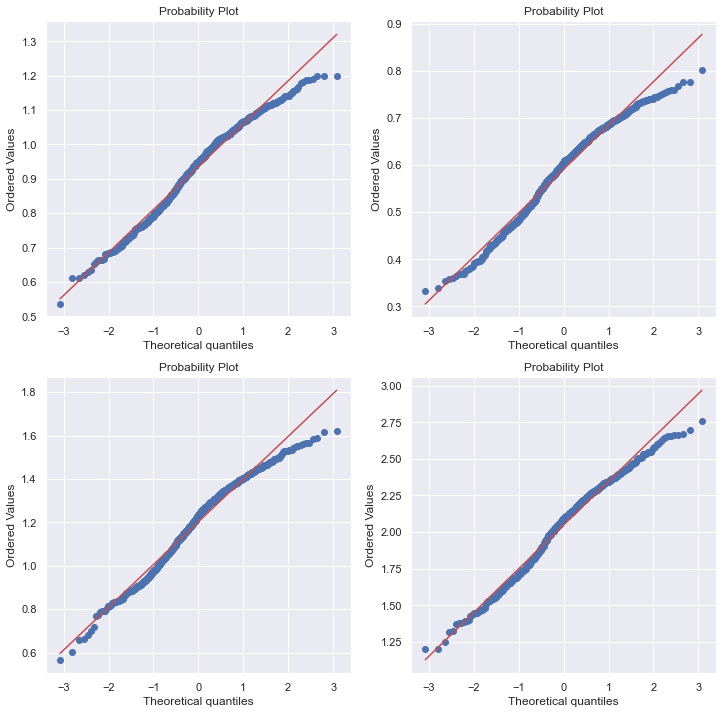

In [44]:
plt.subplots(figsize=(12, 12))
plt.subplot(221)
pr1=probplot(Xr[:,0], plot=plt)
plt.subplot(222)
pr2=probplot(Xr[:,1],plot=plt)
plt.subplot(223)
pr3=probplot(Xr[:,2], plot=plt)
plt.subplot(224)
pr4=probplot(Xr[:,3], plot=plt)

The color reconstructed distrbutions are normal. There are derivations from the normal distribution.

In [45]:
from scipy.stats import shapiro
# The Shapiro-Wilk test tests the null hypothesis 
# that the data was drawn from a normal distribution.
# For N > 5000 the W test statistic is accurate but the p-value may not be.
# The chance of rejecting the null hypothesis when it is true 
# is close to 5% regardless of sample size.
W, p_SW = shapiro(Xr[:, 0])
print("W:", W)
print("p-value:", p_SW)

W: 0.9817537748937334
p-value: 2.068292371956084e-07


The Shapiro-Wilk test results also indicate that we have to 
reject the hypothesis of normal distribution.

We have described a simple way to sample the TNO/Centaur color joint distrbutions by using a combination of Box-Cox, scalling, and PCA transform.

#### Non-negative Matrix Factorization

Aim:
Find two non-negative matrices (W, H) whose product approximates the non- negative matrix X (X=WH). This factorization can be used for example for dimensionality reduction, source separation or topic extraction.

Advantages:
- can be used for signal-to-noise data
- measure the uncertainties within the data
- provide an accurate set of derived basis functions.

Desadvatange:
- the eNMF object is non-convex, multiple restarts is required
- there is no assurance that a global minimum is reached
- one needs to minimize the residual error to search for the "best" transform

References:

- “Algorithms for nonnegative matrix factorization with the beta-divergence” C. Fevotte, J. Idier, 2011
- “Fast local algorithms for large scale nonnegative matrix and tensor factorizations.” A. Cichocki, P. Anh-Huy, 2009

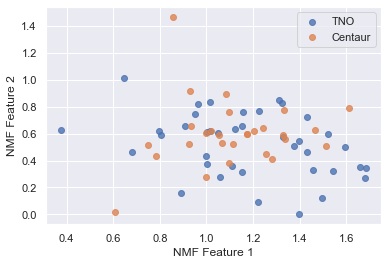

NMA transform error: 0.007926280173063497
Loadings


,Color,NMF 1,NMF 2,NMF 3,NMF 4
0,B-V,0.290395,0.477480,0.000000,0.576377
1,V-R,0.119056,0.180321,0.302630,0.384727
2,V-I,0.266093,0.632621,0.576793,0.422647
3,V-J,1.146756,0.536322,0.498423,0.063806


In [46]:
from sklearn.decomposition import NMF
# the results depend strongly on the random_state
nmf_model = NMF(n_components=4, init='random', random_state=20, max_iter=500)
X = np.array(df_data_noClass)
nmf_model.fit(X)
Xnmf = nmf_model.transform(X)
plot_Data(Xnmf[wTNO, 0:2],Xnmf[wCentaur, 0:2],'NMF', 'TNO', 'Centaur')
colors_nmf=pd.DataFrame(['B-V', 'V-R', 'V-I', 'V-J'])
# the NMF components
df_nmf = pd.DataFrame(np.transpose(nmf_model.components_))
df_nmf = pd.concat([colors_nmf, df_nmf], axis='columns')
df_nmf.columns=['Color', 'NMF 1', 'NMF 2', 'NMF 3', 'NMF 4']
# the transform error can be used to find the best decomposition
print("NMA transform error:", nmf_model.reconstruction_err_)
print("Loadings")
df_nmf

In [47]:
woutlier=np.array(np.where(Xnmf[:, 1] > 1.4))
df.iloc[woutlier[0], :]

,Objects,Type,B-V,err(B-V),V-R,err(V-R),V-I,err(V-I),V-J,err(V-J),Class,Ref
41,2001 UR163,Centaur,1.13,0.05,0.84,0.03,1.96,0.07,2.37,0.06,1,Nasa


In [48]:
df_Xnmf=pd.DataFrame(Xnmf)
df_Xnmf.columns=['NMF 1', 'NMF 2', 'NMF 3', 'NMF 4']
df_Xnmf.iloc[woutlier[0], :]

,NMF 1,NMF 2,NMF 3,NMF 4
40,0.856616,1.467411,1.164712,0.313252


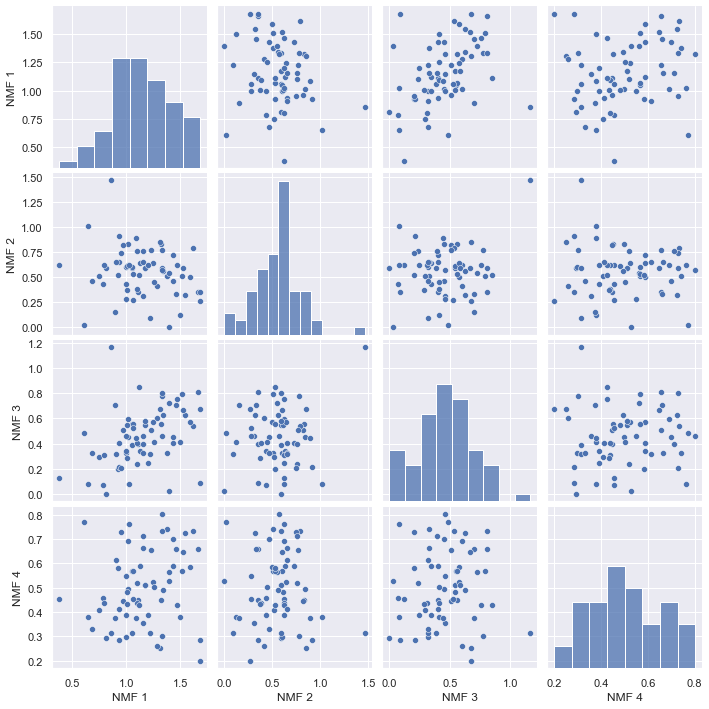

In [49]:
sns.pairplot(df_Xnmf)
plt.show()

In [50]:
df_err=df[['err(B-V)', 'err(V-R)', 'err(V-I)', 'err(V-J)']]

In [51]:
df_err.head()

,err(B-V),err(V-R),err(V-I),err(V-J)
1,0.17,0.09,0.10,0.08
2,0.18,0.15,0.15,0.11
3,0.20,0.12,0.06,0.13
4,0.08,0.16,0.16,0.11
5,0.08,0.08,0.08,0.14


In [52]:
df_data = df[['B-V', 'V-R', 'V-I', 'V-J', 'Class']]

In [53]:
X = np.array(df_data.iloc[:, 1:4])
y = np.array(df_data.iloc[:, 4])

In [54]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=2018)

In [55]:
from sklearn.model_selection import StratifiedKFold, cross_val_predict, cross_val_score
from sklearn.ensemble import RandomForestClassifier

In [56]:
kfold  = StratifiedKFold(n_splits=5, random_state=2017, shuffle=True)
clf = RandomForestClassifier(n_estimators=200, max_depth=3, random_state=1).fit(X_train, y_train)
results = cross_val_score(clf, X_train, y_train, cv=kfold)
print('CV score:',results.mean())

y_train_pred=clf.predict(X_train)
y_test_pred =clf.predict(X_test)

train_score = clf.score(X_train, y_train)
test_score  = clf.score(X_test, y_test)
print(train_score, test_score)

CV score: 0.62
0.9 0.47058823529411764


In [57]:
from xgboost.sklearn import XGBClassifier  # use the XGBoost routine
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=3)
clf = XGBClassifier(n_estimators = 200, max_depth=3, early_stopping_rounds=20,
                    objective= 'binary:logistic',
                    seed=100)
clf.fit(X_train,y_train, eval_set=[(X_test, y_test)], verbose=False)

y_train_pred=clf.predict(X_train)
y_test_pred =clf.predict(X_test)
train_score = clf.score(X_train, y_train)
test_score  = clf.score(X_test, y_test)
print(train_score,test_score)

0.8 0.5882352941176471


In [58]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=2018)
n_folds = 5
kfold = StratifiedKFold(n_splits=n_folds, shuffle=True,random_state=2)
cv_train_score = []
cv_val_score = []
cv_test_score = []
clf = XGBClassifier(n_estimators=200,max_depth=3, early_stopping_rounds=20,
                    objective='binary:logistic',
                    seed=100)
k = 1
for t, v in kfold.split(X_train, y_train):
    print('fold ',k,' train size: ',t.size,' validation size: ', v.size)
    Xtr  =  X_train[t]
    ytr  =  y_train[t]
    Xval =  X_train[v]
    yval =  y_train[v]
    clf.fit(Xtr, ytr, eval_set=[(Xval, yval)], verbose=False)
    cv_train_score.append(clf.score(Xtr, ytr))
    cv_val_score.append(clf.score(Xval, yval))
    cv_test_score.append(clf.score(X_test, y_test))
    k = k +1
cv_train_score = np.array(cv_train_score)
cv_test_score = np.array(cv_test_score)
cv_val_score = np.array(cv_val_score)
print(cv_train_score.mean(), cv_val_score.mean(), cv_test_score.mean())

fold  1  train size:  40  validation size:  10
fold  2  train size:  40  validation size:  10
fold  3  train size:  40  validation size:  10
fold  4  train size:  40  validation size:  10
fold  5  train size:  40  validation size:  10
0.8699999999999999 0.68 0.5529411764705883


The classifiers fail to find a way to discrimimate the two classes based on their colors only.

In [59]:
from sklearn.svm import SVC 
clf = SVC(kernel='linear', C=1e3).fit(X_train, y_train)
results = cross_val_score(clf, X_train, y_train, cv=kfold)
print('CV score:', results.mean())

y_train_pred=clf.predict(X_train)
y_test_pred =clf.predict(X_test)

train_score = clf.score(X_train, y_train)
test_score  = clf.score(X_test, y_test)
print(train_score,test_score)

CV score: 0.48
0.56 0.6470588235294118


### 13/06/2018 use the automatic machine learning pipeline tpot

In [ ]:
#!python3.9 -m pip install tpot

In [61]:
from tpot import TPOTClassifier

In [ ]:
tpot = TPOTClassifier(generations=10, verbosity=2) 
tpot.fit(X_train, y_train) 

Optimization Progress:   0%|          | 0/1100 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.72

Generation 2 - Current best internal CV score: 0.72

Generation 3 - Current best internal CV score: 0.74

Generation 4 - Current best internal CV score: 0.76

Generation 5 - Current best internal CV score: 0.76

Generation 6 - Current best internal CV score: 0.76


In [ ]:
print(tpot.score(X_test, y_test)) 

In [ ]:
tpot.export('tpot_planetesimals_pipeline.py')